# Data Challenge - Semester 6 Advanced AI - Steven Ly

## 📃 Context
The domain of this data challenge is the food and beverages industry. Specifically, it is about the cafeteria business Den Besterd in Tilburg. This local cafetaria sells typical Dutch fries and snacks and includes sales data of food items.

My innovative idea is to apply deep learning models to predict the optimal timing for selling certain
food items within periods such as a week or month. My goal is to leverage effective deep learning
models so that in the future, new opportunities arise in making deals based on the predictions the
model has made. When certain food items are about to trend, it is possible to promote those items
early on in the trend. This technique could provide a competitive advantage in the food and beverage
industry within our area, as we would be able to implement sales strategies in advance when certain
food items are about to trend.

## 📅 Data
Den Besterd employs the POS system "Sitedish" for local ordering and "Just Eat" otherwise known as "Thuisbezorgd" for food deliveries. Sitedish is a company that provides a POS system and a website in which users can adjust the products, set opening times and download various data. The data of Sitedish and Thuisbezorgd are downloadable through the Sitedish online platform. However, it is not very accessible to download food item data periodically, as this approach misses information about the specific periods when food items were ordered.

Before I started working on this notebook, I developed a web scraper with the python library Selenium for obtaining the daily food item csv data given the inconvenient accessibility of obtaining the data from Sitedish. The script for the web scraper can be found as "selenium-webautomation-daily.py" or "selenium-webautomation-periodically.py".

I have chosen to obtain the archived data from the period between the end of 2021 and April 2024, as the end of 2021 marks the period nearing the end of COVID.

## 📑 Ethics
One of the ethical aspects of my challenge is that my model would be utilized when it lacks precision
and trustworthiness. If the model generates false predictions and the users subsequently end up
making the wrong decision, it could result in financial losses. Additionally, feeding customer data into
the AI model raises privacy concerns. Proper anonymization of sensitive customer information is
crucial.

## The code

We firstly analyze the dataset of the POS system Sitedish. The data is nested within the folder directory 'Data/POS_daily' and is structured as "{system}__{start_date}". In the second code cell below, we will gather all the daily .csv data from the folder directory and construct a dataframe that captures information from each CSV file.

In [1]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
folder_path = 'Data/POS_daily'

# Use glob to get all CSV files in the folder
csv_files = glob.glob(f'{folder_path}/*.csv')

# An empty list to store the DataFrames
df_list = []

# The csv files from the data folder are structured as "{system}__{start_date}". The regular expression extracts the date information from the filename.
pattern = re.compile(r'POS__(\d{4}-\d{2}-\d{2})')

# Loop over the list of files and read each file into a DataFrame
for file in csv_files:
    match = pattern.search(file)
    if match:
        csv_date_start = match.groups()[0]

        df = pd.read_csv(file)

        df['date'] = csv_date_start
        df['date'] = pd.to_datetime(df['date'])
        # temp_year = df['date'].dt.year
        # temp_week = df['date'].dt.isocalendar().week
        # df['yearly_week'] = temp_year.astype(str) + '-W' + temp_week.astype(str).str.zfill(2)
        
        df_list.append(df)
    else:
        print(f"mismatch: {file}")

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(df_list)
combined_df.drop('laatst_besteld', inplace=True, axis=1) # Dropped this column since it is not relevant for analyzing trending food item data

combined_df = combined_df.rename(columns={"gerecht":"food_item", "prijs_€":"price", "aantal_bestellingen":"amount_of_orders"})
combined_df['food_item'] = combined_df['food_item'].str.strip()

combined_df

,food_item,price,amount_of_orders,date
0,Frikandel,1.80,20,2021-07-01
1,Friet,2.00,14,2021-07-01
2,Friet speciaal,3.10,12,2021-07-01
3,Frikandel speciaal,3.00,11,2021-07-01
4,Friet mayonaise,2.55,8,2021-07-01
...,...,...,...,...
34,Red Bull,2.75,1,2024-04-30
35,Sitostick,2.80,1,2024-04-30
36,Speksnack,2.40,1,2024-04-30
37,Sundae Caramel topper,3.25,1,2024-04-30


In [3]:
# Settings the index to be the date for analyzing time series data
combined_df.set_index('date', inplace=True)

start_date = combined_df.index.min()
end_date = combined_df.index.max()

print("First Date:", start_date.strftime("%Y %m %d"))
print("Last Date:", end_date.strftime("%Y %m %d"))

First Date: 2021 07 01
Last Date: 2024 04 30


As we can see the data is obtained from the period between July 1st 2021 (2021-07-01) and April 30th 2024 (2024-04-30). The data features every date as the index and includes columns for the food items sold, their prices, and the quantity sold.

# Additional cleaning after modelling

In this section the individual food items will be analyzed and cleaned as this step could potentially avoid false conclusions. This includes food items which have special characters, extra annotations, or capitalizations. Additionally, food items that have less than 30 orders will be removed from the dataset.

## Removing unmeaningful food items in the dataset

As seen in the codecell below, some of these items such as "1", "1/2 b.ss", "13x scooberservice", "2x brood", are not relevant the dataset as they are just noise and will be removed. Therefore, a dictionary of unmeaningful food items will be created and used to remove these items from the dataset.

In [4]:
print("First 5 unique food items:", sorted(combined_df.food_item.unique())[0:5])
print("Last 5 unique food items:", sorted(combined_df.food_item.unique())[-5:])

First 5 unique food items: ['1', '1/2 b.ss', '13x scooberservice', '2x brood', '2x broodje']
Last 5 unique food items: ['varkenssates met satesaus', 'xtr', 'xtra. vlees', 'xtra.vlees', 'zacht brood']


In [5]:
unmeaningful_food_items = [
    "1",
    "1/2 b.ss",
    "13x scooberservice",
    "2x brood",
    "2x broodje",
    "BROODJE",
    "Bezorgd",
    "Brood",
    "bier",
    "Cadeaubon",
    "De Stappen",
    "Eigen invoer",
    "Extra",
    "Thuisbez.52PW5U",
    "VLEES",
    "`",
    "bezorgkosten",
    "bord",
    "borrelhapjes",
    "brood",
    "broodje",
    "cadeaubon",
    "cap",
    "dip",
    "divers",
    "diverse",
    "diverse snacks",
    "ei",
    "eten voor kleptijd",
    "extra strogsnof",
    "extra vlees",
    "hamb",
    "kost",
    "kosten",
    "meerprijs f",
    "midde",
    "nootjes",
    "op bord serveren",
    "saus",
    "thuisbez.",
    "thuisbez.23h8sl",
    "thuisbez.9ut7gn",
    "thuisbez.akf7oe",
    "thuisbez.jmtte8",
    "thuisbez.ocblas",
    "thuisbez.v8amzn",
    "thuisbez.wasa20",
    "thuisbez.xyfpvy",
    "thuisbezrgd 45ELCC",
    "xtr",
    "xtra. vlees",
    "xtra.vlees",
    "zacht brood"
]

combined_df = combined_df[~combined_df['food_item'].isin(unmeaningful_food_items)]

### Cleaning food items with extra annotations or capitalizations

In the codecells below, the food items will be cleaned by converting all the food items to lowercase and removing any extra annotations. As an example, "halve b.ss", "halve beker sate", "halve beker satesaus" will be converted to "halve beker satésaus" as point to the same food item. A dictionary of duplicate food items will be created and used to replace the duplicate food items with the correct food item.

In [6]:
temp_combined_df = combined_df.copy()
temp_combined_df['food_item'] = temp_combined_df['food_item'].str.lower()
temp_combined_df

,food_item,price,amount_of_orders
date,,,
2021-07-01,frikandel,1.80,20
2021-07-01,friet,2.00,14
2021-07-01,friet speciaal,3.10,12
2021-07-01,frikandel speciaal,3.00,11
2021-07-01,friet mayonaise,2.55,8
...,...,...,...
2024-04-30,red bull,2.75,1
2024-04-30,sitostick,2.80,1
2024-04-30,speksnack,2.40,1


In [7]:
duplicate_item_dict = {
    "asianbox chickenstrip ( 5 st )" : "asianbox chickenstrip",
    "beker champi. roomsaus" : "beker champignonsroomsaus",
    "bucket friet groot (≥ 6 personen)" : "bucket friet groot",
    "bucket friet klein (± 4 personen)" : "bucket friet klein",
    "bucket friet middel (± 5 personen)" : "bucket friet middel",
    "fricandel zero" : "frikandel zero",
    "kipburger" : "chicken burger",
    "crispy  garnalen" : "crispy shrimps",
    "familiezak friet groot (± 3 personen)" : "familiezak friet groot",
    "familiezak friet klein ( ± 2 personen)" : "familiezak friet klein",
    "friet den besterd ( varkensvleesreepjes v/d bakplaat met knoflooksaus )" : "friet den besterd",
    "friet oorlog ( spec.en satésaus )" : "friet oorlog",
    "halve b.ss" : "halve beker satésaus",
    "halve beker sate" : "halve beker satésaus",
    "halve beker satesaus" : "halve beker satésaus",
    "halve beker ss" : "halve beker satésaus",
    "halve bk ss" : "halve beker satésaus",
    "halve ss" : "halve beker satésaus",
    "kinderijs" : "kinder ijs", 
    "lipton ice ice tea" : "lipton ice tea",
    "mini loempia" : "mini loempia's",
    "mini loempia ( 8 st )" : "mini loempia's",
    "milkshake vanilie" : "milkshake vanille",
    "obliehorn" : "obliehoorn",
    "portie bitterballen ( 6 st. )" : "portie bitterballen",
    "portie kipsaté v/d bakplaat" : "portie kipsaté",
    "kipsaté" : "portie kipsaté",
    "rode wijn ( flesje )" : "rode wijn",
    "rundvleeskroket bourgondiër" : "bourgondiërkroket",
    "sundae     met chocoladesaus" : "sundae chocolade",
    "sundae met aardbeiensaus" : "sundae aardbeien",
    "sundae met caramelsaus" : "sundae caramel",
    "sundae caramel topper" : "sundae caramel",
    "vietnamese loempia met chillisaus ( 2 st )" : "vietnamese loempia"
}

In [8]:
temp_combined_df['food_item'] = temp_combined_df['food_item'].replace(duplicate_item_dict)

In [9]:
# Aggregate the amount of orders per food item
grouped_df = temp_combined_df.groupby('food_item', as_index=False).agg({
    'food_item': 'first',
    'amount_of_orders': 'sum'
})

grouped_df = grouped_df[grouped_df['amount_of_orders'] >= 30]
grouped_df.sort_values(by='amount_of_orders', ascending=True)

,food_item,amount_of_orders
263,vietnamese loempia,30
209,portie tomotto saus,30
162,menu easy egg burger,32
122,ijs beker small,35
169,menu lekkerbek,35
...,...,...
143,kroket,6534
90,friet speciaal,6619
95,frikandel,8027
75,friet,8125


In [10]:
temp_combined_df

,food_item,price,amount_of_orders
date,,,
2021-07-01,frikandel,1.80,20
2021-07-01,friet,2.00,14
2021-07-01,friet speciaal,3.10,12
2021-07-01,frikandel speciaal,3.00,11
2021-07-01,friet mayonaise,2.55,8
...,...,...,...
2024-04-30,red bull,2.75,1
2024-04-30,sitostick,2.80,1
2024-04-30,speksnack,2.40,1


In [11]:
# remove the food items that have less than 30 orders as the sample size for these items are too small for the period of 3 years.
temp_combined_df = temp_combined_df[temp_combined_df['food_item'].isin(grouped_df['food_item'])]

In [12]:
combined_df = temp_combined_df

# Data Visualisation
In the codecell below I have made a helper function for plotting out a line plot with matplotlib.

In [13]:
def create_plot(index, dataframe, label="Data", xlabel="X", ylabel="Y", title=None, xlim=None, ylim=None, figsize=(12,6), legend=False, highlights=None):
    plt.figure(figsize=figsize)
    plt.plot(index, dataframe, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True)
    plt.tight_layout()
    if legend:
        plt.legend()
    if highlights:
        start, end = highlights
        plt.axvspan(start, end, facecolor='yellow', alpha=0.5, hatch='/', edgecolor='red', linewidth=2)

    plt.show()

In the codecell we can plot out the amount of orders given the period between 2021-07-01 and 2021-12-31. This is first month of the dataset. 

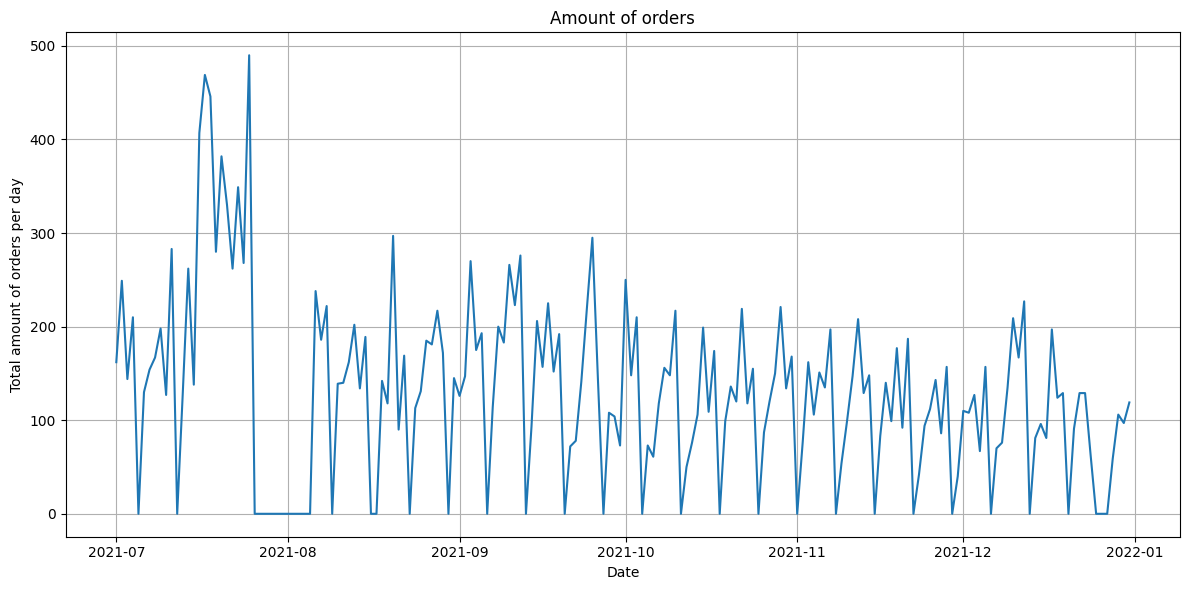

In [14]:
# Group by orders and calculate the total amount of orders for each date
orders_df = combined_df.groupby(combined_df.index).apply(
    lambda x: x['amount_of_orders'].sum()
)

date_range = pd.date_range(start='2021-07-01', end='2021-12-31')
orders_df = orders_df.reindex(date_range, fill_value=0)

create_plot(orders_df.index, orders_df, "Total amount of orders per day", "Date", "Total amount of orders per day", "Amount of orders")

As we can see there is a substantial increase of amount of orders after 2021-07-16, this is not an outlier since this week it was Kermis in Tilburg which is an event that attracts a lot of customers. On the left side of the plot, following the peak week, the number of orders per day drops to zero for a period, reflecting Den Besterd's closure for the holidays. Additionally, every 7th day the total amount of orders per day decreases to 0 as this is the non-working-day of Den Besterd.

In the codeblock below we analyse the revenue as well, which is the price multiplied by the amount of orders per food item. 

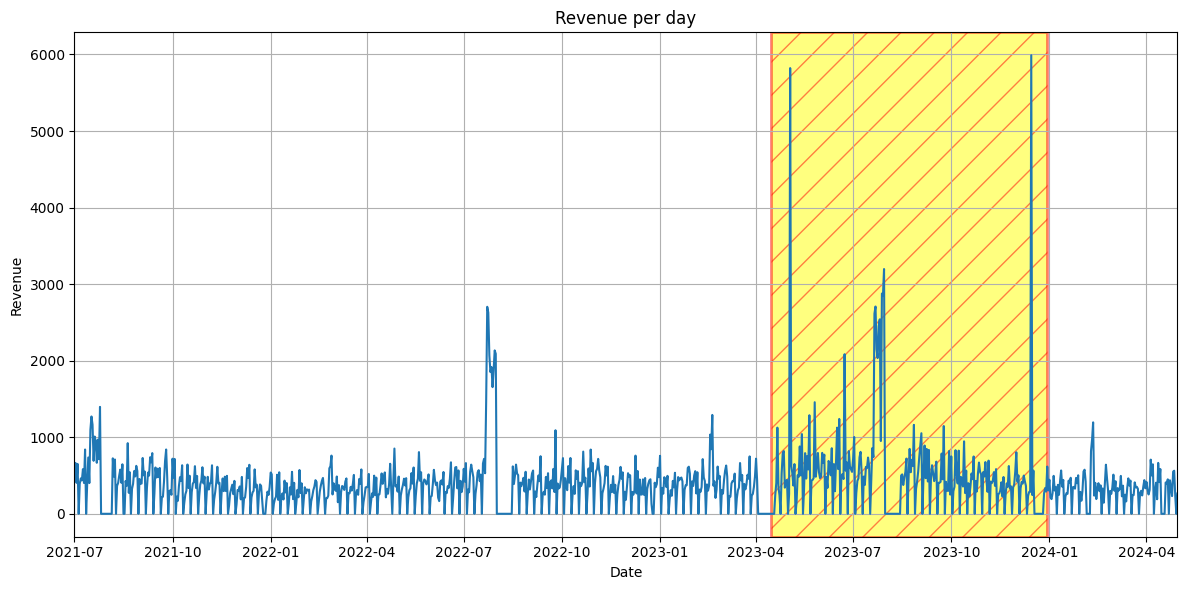

In [15]:
# Group by date and calculate the total revenue for each date
revenue_df = combined_df.groupby(combined_df.index).apply(
    lambda x: (x['price'] * x['amount_of_orders']).sum()
)

date_range = pd.date_range(start=start_date, end=end_date)
revenue_df = revenue_df.reindex(date_range, fill_value=0)


create_plot(revenue_df.index, revenue_df, "Revenue per day", "Date", "Revenue", "Revenue per day", xlim=(start_date, end_date), highlights=('2023-04-15','2023-12-30'))

The yellow highlighted zone in the line plot indicates the region with significant outliers. As we can see there are two points that stand out prominently. In the code cell below, we visualize what those two points represent.

In [16]:
revenue_df.sort_values(ascending=False)[:5]

2023-12-15    5989.55
2023-05-03    5821.90
2023-07-30    3197.00
2023-07-28    2877.15
2023-07-29    2852.60
dtype: float64

In [17]:
combined_df.loc['2023-12-15']

,food_item,price,amount_of_orders
date,,,
2023-12-15,frikandel speciaal,3.25,151
2023-12-15,friet,2.20,139
2023-12-15,frikandel,1.95,126
2023-12-15,friet speciaal,3.70,89
2023-12-15,kroket,1.95,85
...,...,...,...
2023-12-15,shooter,3.40,1
2023-12-15,sorbet kersen,4.00,1
2023-12-15,spa rood,2.50,1


I have done an analysis of the two points, which are 2023-12-15 and 2023-05-03. December 15th 2023 represents "Koningsrijkdag". However, It was not evident what special day April 3rd 2023 was. After further investigation on these dates it was not clear where the outliers came from. Therefore, I have decided to remove these two points from the dataset.

In the codecells below we remove the two points from the dataset and plot the revenue per day after the removal.

In [18]:
combined_df = combined_df.drop(index=pd.to_datetime(['2023-12-15','2023-05-03']))

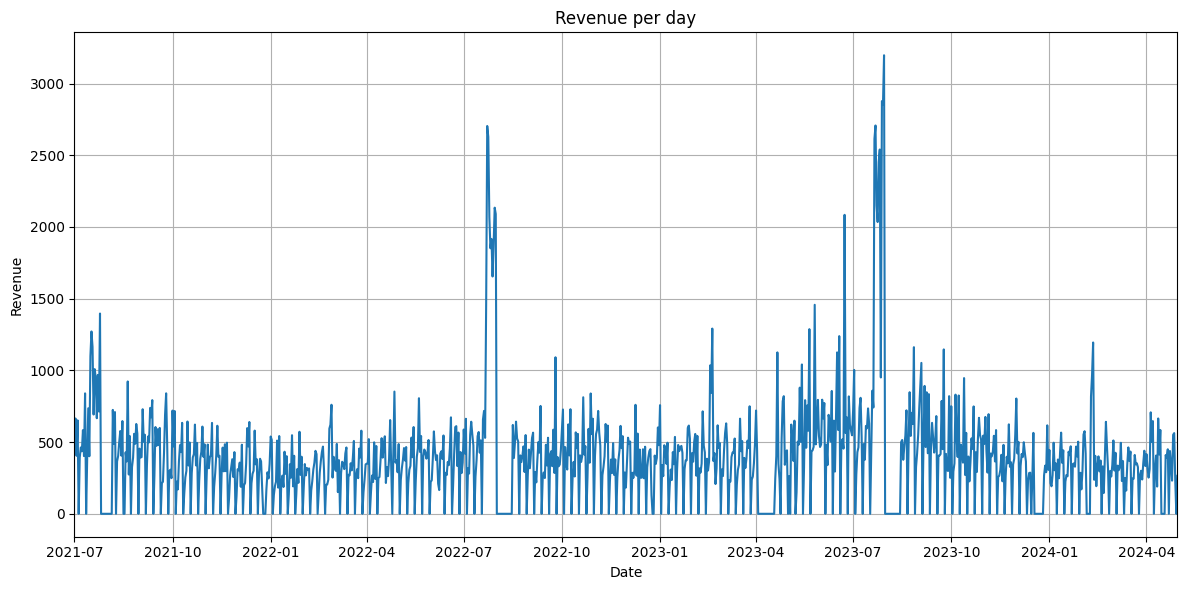

In [19]:
revenue_df = combined_df.groupby(combined_df.index).apply(
    lambda x: (x['price'] * x['amount_of_orders']).sum()
)

date_range = pd.date_range(start=start_date, end=end_date)
revenue_df = revenue_df.reindex(date_range, fill_value=0)

create_plot(revenue_df.index, revenue_df, "Revenue per day", "Date", "Revenue", "Revenue per day", xlim=(start_date, end_date))

In the codecell below we will analyze the top 10 food items that have been ordered the most. We will then plot the trends of these food items over time grouped by month.

In [20]:
total_orders = combined_df.groupby('food_item')['amount_of_orders'].sum()
top_10_items = total_orders.nlargest(10).index
top_10_items

Index(['frikandel speciaal', 'friet', 'frikandel', 'friet speciaal', 'kroket',
       'friet mayonaise', 'friet satésaus', 'kaassouflé', 'friet stoofvlees',
       'mexicano'],
      dtype='object', name='food_item')

In [21]:
monthly_orders_df = combined_df.groupby([pd.Grouper(freq='ME'), 'food_item']).sum().reset_index()
monthly_orders_df = monthly_orders_df.drop('price', axis=1)
monthly_orders_df

,date,food_item,amount_of_orders
0,2021-07-31,3d beker,26
1,2021-07-31,alaska fish burger,5
2,2021-07-31,appelsap,14
3,2021-07-31,bacon bite burger,40
4,2021-07-31,bami oriental,18
...,...,...,...
4680,2024-04-30,sundae caramel,8
4681,2024-04-30,sundae stroopwafel topper,5
4682,2024-04-30,variastick,9
4683,2024-04-30,viandel,65


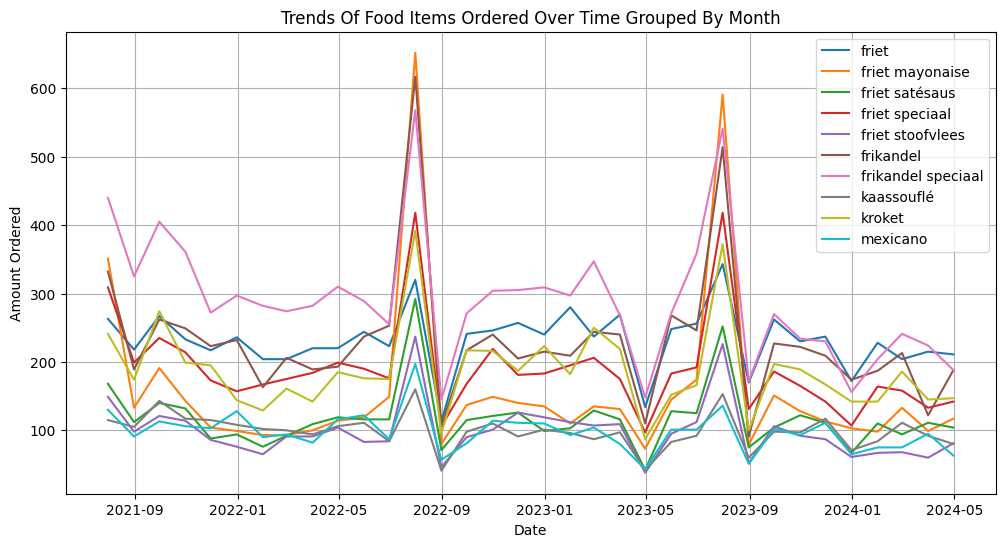

In [22]:
top_10_filtered_df = monthly_orders_df[monthly_orders_df['food_item'].isin(top_10_items)]

top_10_pivot_df = top_10_filtered_df.pivot_table(index='date', columns='food_item', values='amount_of_orders', aggfunc='sum')

plt.figure(figsize=(12, 6))

for column in top_10_pivot_df.columns:
    plt.plot(top_10_pivot_df.index, top_10_pivot_df[column], label=column)

plt.xlabel('Date')
plt.ylabel('Amount Ordered')
plt.title('Trends Of Food Items Ordered Over Time Grouped By Month')
plt.legend()
plt.grid(True)

plt.show()

# Preprocessing

In this section we will preprocess the data for only the deep learning model, which entrails creating a pivot table, normalizing the data and creating sequences of 30-days for the model. The pivot table will contain the food items as columns and the date as the index. I have chosen for a pivot table since each food item will contain the amount of orders separated by date. I have created sequences of 30 days for the LSTM model to predict the trending food items. 

I have chosen to apply a 70-20-10 split for the training, testing, and validation set.

In [23]:
daily_pivot = combined_df.pivot_table(index='date', columns='food_item', values='amount_of_orders', aggfunc='sum').fillna(0)
daily_pivot

food_item,3d beker,alaska fish burger,appelsap,bacon bite burger,bami oriental,bamihap,bavaria bier,beker champignonsroomsaus,beker satésaus,beker stoofvlees,...,sundae caramel,sundae chocolade,sundae stroopwafel topper,thee,variastick,viandel,vietnamese loempia,visstick,witte wijn ( flesje ),zubr
date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,0.0,0.0,0.0,3.0,0.0,5.0,1.0,0.0,2.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-07-02,1.0,0.0,0.0,2.0,1.0,7.0,1.0,0.0,3.0,1.0,...,0.0,1.0,0.0,0.0,2.0,13.0,1.0,1.0,0.0,2.0
2021-07-03,0.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,0.0,1.0,...,1.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2021-07-04,0.0,2.0,0.0,2.0,1.0,3.0,1.0,0.0,5.0,0.0,...,1.0,0.0,0.0,0.0,1.0,5.0,2.0,0.0,0.0,0.0
2021-07-06,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-25,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2024-04-26,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2024-04-27,0.0,0.0,0.0,0.0,2.0,6.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [24]:
def normalize_dataframe(dataframe):
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(scaler.fit_transform(dataframe), index=dataframe.index, columns=dataframe.columns)
    return scaler, normalized_df

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length].values
        y = data.iloc[i + seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [25]:
SEQ_LENGTH = 30
daily_pivot_scaler, daily_pivot_normalized = normalize_dataframe(daily_pivot)
X, y = create_sequences(daily_pivot_normalized, SEQ_LENGTH)
print(X.shape, y.shape)

(803, 30, 165) (803, 165)


In [26]:
X_train, y_train = X[:562], y[:562]
X_test, y_test = X[562:722], y[562:722]
X_val, y_val = X[722:], y[722:]

print("Train dimensions: ", X_train.shape, y_train.shape)
print("Test dimensions: ", X_test.shape, y_test.shape)

Train dimensions:  (562, 30, 165) (562, 165)
Test dimensions:  (160, 30, 165) (160, 165)


# Modelling

I have chosen to use Long Short-Term Memory (LSTM) as a deep learning model for predicting the trending food items on a 30-day sequential basis. I have chosen to measure the model's performance using the Mean Squared Error (MSE) metric as this metric is suitable for predicting continuous values such as amount of orders. The model will be trained for 1500 epochs.


I have trained LSTM with the following network configurations:


| L1:LSTM(50), L2:LSTM(50), L3:Dense(25)                                                                 |
|--------------------------------------------------------------------------------------------------------|
| Epoch 100: loss = 0.008, mean_squared_error = 0.008, val_loss = 0.015, val_mean_squared_error = 0.015  |
| Epoch 500: loss = 0.006, mean_squared_error = 0.006, val_loss = 0.020, val_mean_squared_error = 0.020  |
| Epoch 1000: loss = 0.006, mean_squared_error = 0.006, val_loss = 0.017, val_mean_squared_error = 0.017 |

| L1:LSTM(50), L2:LSTM(50) |
|--------------------------------------------------------------------------------------------------------|
| Epoch 100: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.016, val_mean_squared_error = 0.016 |
| Epoch 500: loss = 0.004, mean_squared_error = 0.004, val_loss = 0.028, val_mean_squared_error = 0.028 |
| Epoch 1000: loss = 0.004, mean_squared_error = 0.004, val_loss = 0.030, val_mean_squared_error = 0.030 |

| L1:LSTM(128), L2:LSTM(64), L3:Dense(25)                                                               |
|-------------------------------------------------------------------------------------------------------|
| Epoch 100: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.015, val_mean_squared_error = 0.015 |
| Epoch 500: loss = 0.006, mean_squared_error = 0.006, val_loss = 0.014, val_mean_squared_error = 0.014 |
| Epoch 1000: loss = 0.006, mean_squared_error = 0.006, val_loss = 0.013, val_mean_squared_error = 0.013 |

In [27]:
from keras.src.layers import LSTM, Dense
from keras import Sequential, Input

model = Sequential()
print(SEQ_LENGTH, X.shape[2])
model.add(Input(shape=(SEQ_LENGTH, X.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(y_train.shape[1]))  # Predicting 'orders'

model.summary()

30 165


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │       150,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 165)            │         4,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,851 (804.11 KB)

 Trainable params: 205,851 (804.11 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from keras.src.optimizers import Adam
from keras.src.callbacks import ModelCheckpoint, LambdaCallback

checkpoint = ModelCheckpoint('models/model1.keras', monitor='val_loss', save_best_only=True)
log_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs:
    print(f"Epoch {epoch + 1}: loss = {logs['loss']:.3f}, mean_squared_error = {logs['mean_squared_error']:.3f}, val_loss = {logs['val_loss']:.3f}, val_mean_squared_error = {logs['val_mean_squared_error']:.3f}")
    if (epoch + 1) % 100 == 0 else None
)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])

In [29]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1500, callbacks=[checkpoint, log_callback], verbose=0)

Epoch 100: loss = 0.010, mean_squared_error = 0.010, val_loss = 0.022, val_mean_squared_error = 0.022
Epoch 200: loss = 0.008, mean_squared_error = 0.008, val_loss = 0.024, val_mean_squared_error = 0.024
Epoch 300: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.023, val_mean_squared_error = 0.023
Epoch 400: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.022, val_mean_squared_error = 0.022
Epoch 500: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.021, val_mean_squared_error = 0.021
Epoch 600: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.020, val_mean_squared_error = 0.020
Epoch 700: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.019, val_mean_squared_error = 0.019
Epoch 800: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.019, val_mean_squared_error = 0.019
Epoch 900: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.019, val_mean_squared_error = 0.019
Epoch 1000: loss = 0.007, mean_squared_error = 0.007, val_loss = 0.019, val_mean_s

In [30]:
# Get the last sequence from the test set
last_sequence = X_test[-1].reshape((1, SEQ_LENGTH, X_train.shape[2]))

# Predict the last sequence
predicted_orders = model.predict(last_sequence).flatten()
predicted_df = pd.DataFrame(data=[predicted_orders], columns=daily_pivot_normalized.columns)

# Inverse transform to get actual values
predicted_df = pd.DataFrame(daily_pivot_scaler.inverse_transform(predicted_df), columns=daily_pivot_normalized.columns)

# Get the top 40 items
top_40_items = predicted_df.T.sort_values(by=0, ascending=False).head(40)
print("Top 40 Trending Items:")
print(top_40_items)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Top 40 Trending Items:
                                0
food_item                        
frikandel speciaal      10.240718
friet                    9.814794
frikandel                8.609640
friet speciaal           6.745568
kroket                   6.643954
friet mayonaise          4.697512
friet satésaus           4.323049
friet stoofvlees         3.946239
mexicano                 3.844464
bamihap                  3.778566
kaassouflé               3.246077
viandel                  3.102257
familiezak friet klein   2.271527
classic burger           2.027724
kipkorn                  1.902484
goulashkroket            1.756963
beker satésaus           1.690974
kinder ijs               1.671869
coca cola                1.603402
familiezak friet groot   1.492341
sitostick                1.460261
bereklauw                1.458461
obliehoorn               1.383525
cheese burger            1.264685
friet oorlog             1.222095
chicken burger      

In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Evaluate the model on the validation set
loss = model.evaluate(X_val, y_val)

print("Loss (Mean squared error) on the validation set:", loss[0])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0131 - mean_squared_error: 0.0131  
Loss (Mean squared error) on the validation set: 0.012747710570693016


In [51]:
temp = combined_df.groupby([pd.Grouper(freq='ME'), 'food_item']).sum().reset_index()
monthly_pivot = temp.pivot_table(index='date', columns='food_item', values='amount_of_orders', aggfunc='sum').fillna(0)
print(monthly_pivot.shape)
monthly_pivot

(34, 165)


food_item,3d beker,alaska fish burger,appelsap,bacon bite burger,bami oriental,bamihap,bavaria bier,beker champignonsroomsaus,beker satésaus,beker stoofvlees,...,sundae caramel,sundae chocolade,sundae stroopwafel topper,thee,variastick,viandel,vietnamese loempia,visstick,witte wijn ( flesje ),zubr
date,,,,,,,,,,,,,,,,,,,,,
2021-07-31,26.0,5.0,14.0,40.0,18.0,110.0,43.0,2.0,39.0,14.0,...,46.0,15.0,0.0,5.0,19.0,102.0,6.0,5.0,10.0,10.0
2021-08-31,5.0,7.0,4.0,20.0,22.0,76.0,9.0,4.0,37.0,13.0,...,9.0,5.0,0.0,10.0,8.0,59.0,1.0,3.0,1.0,8.0
2021-09-30,5.0,3.0,2.0,12.0,22.0,94.0,27.0,3.0,35.0,14.0,...,19.0,13.0,0.0,0.0,7.0,78.0,2.0,2.0,1.0,23.0
2021-10-31,2.0,3.0,1.0,14.0,24.0,112.0,4.0,1.0,36.0,13.0,...,12.0,2.0,0.0,12.0,15.0,99.0,8.0,6.0,0.0,4.0
2021-11-30,0.0,3.0,1.0,9.0,23.0,95.0,11.0,3.0,32.0,16.0,...,1.0,2.0,0.0,1.0,16.0,64.0,1.0,3.0,0.0,0.0
2021-12-31,0.0,1.0,0.0,15.0,14.0,88.0,3.0,7.0,33.0,17.0,...,5.0,3.0,0.0,0.0,14.0,73.0,1.0,5.0,0.0,0.0
2022-01-31,1.0,1.0,0.0,10.0,22.0,83.0,4.0,1.0,38.0,12.0,...,5.0,4.0,0.0,0.0,14.0,82.0,0.0,1.0,0.0,1.0
2022-02-28,1.0,1.0,4.0,18.0,16.0,73.0,9.0,3.0,35.0,6.0,...,7.0,5.0,0.0,1.0,22.0,79.0,1.0,4.0,0.0,0.0
2022-03-31,4.0,2.0,3.0,11.0,19.0,88.0,10.0,4.0,32.0,12.0,...,5.0,6.0,0.0,6.0,19.0,77.0,0.0,4.0,0.0,0.0


In [33]:
monthly_pivot_scaler, monthly_pivot_normalized = normalize_dataframe(monthly_pivot)

# SARIMA Modelling

To approach the regression problem of predicting trending food items, I have chosen to use the Seasonal AutoRegressive Integrated Moving Average (SARIMA) model as this approach is a statistical way of predicting time series data. The SARIMA model is an extension of the ARIMA model which includes the ability to perform the same autoregression, differencing, and moving average on the seasonal component of the series. 


The optimal parameter per food item will be discovered using the auto_arima function from the pmdarima library. This is a grid search method that iterates over the different parameters. 

In [40]:
from pmdarima import auto_arima


def apply_sarima(item, train_end):
    item = item.asfreq('ME')
    train = item[:train_end]
    test = item[train_end:]

    model = auto_arima(train, seasonal=True, m=12,
                       start_p=0, start_q=0,
                       max_p=5, max_q=5,
                       start_P=0, start_Q=0,
                       max_P=5, max_Q=5,
                       d=1, D=1, trace=False,
                       error_action='ignore',
                       suppress_warnings=True)
    results = model.fit(train)

    forecast = results.predict(n_periods=len(test))
    mse = mean_squared_error(test, forecast)
    
    rmse = np.sqrt(mse)

    return forecast, test, rmse

# Set the train end date
train_end = '2023-12-31'

# Apply SARIMA to each item
forecasts = {}
actuals = {}
rmse_scores = {}

for item in monthly_pivot.columns:
    forecast, test, rmse = apply_sarima(monthly_pivot[item], train_end)
    if forecast is not None:
        forecasts[item] = forecast
        actuals[item] = test.values
    if mse is not None:
        rmse_scores[item] = rmse

# Convert forecasts to a DataFrame
forecast_df = pd.DataFrame(forecasts)
actual_df = pd.DataFrame(actuals)

last_month_forecast = forecast_df.iloc[-1]
trending_items = last_month_forecast.sort_values(ascending=False)

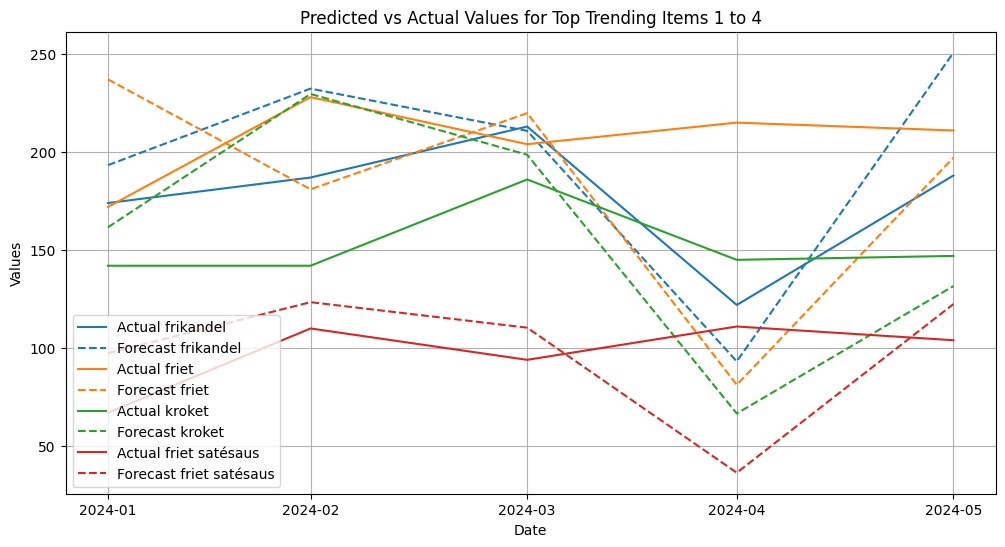

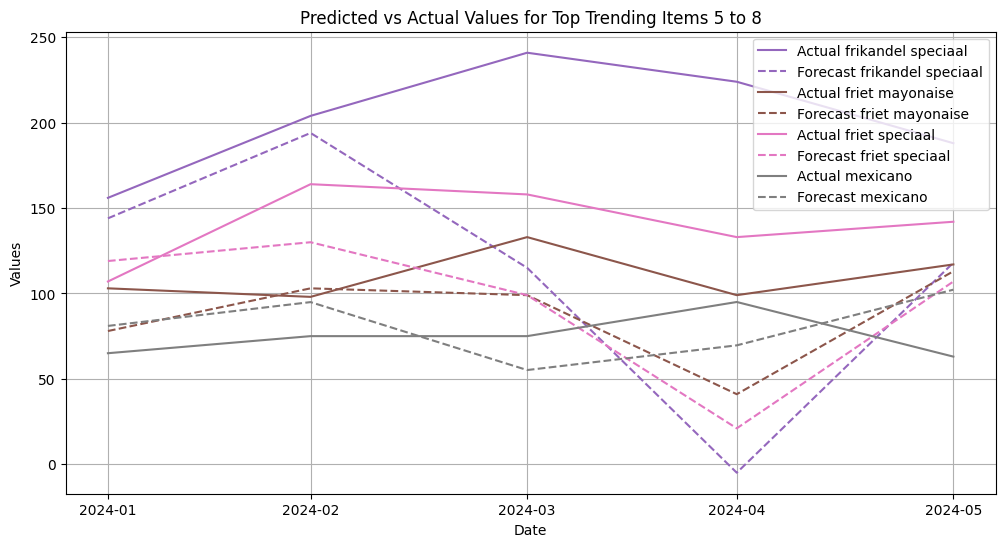

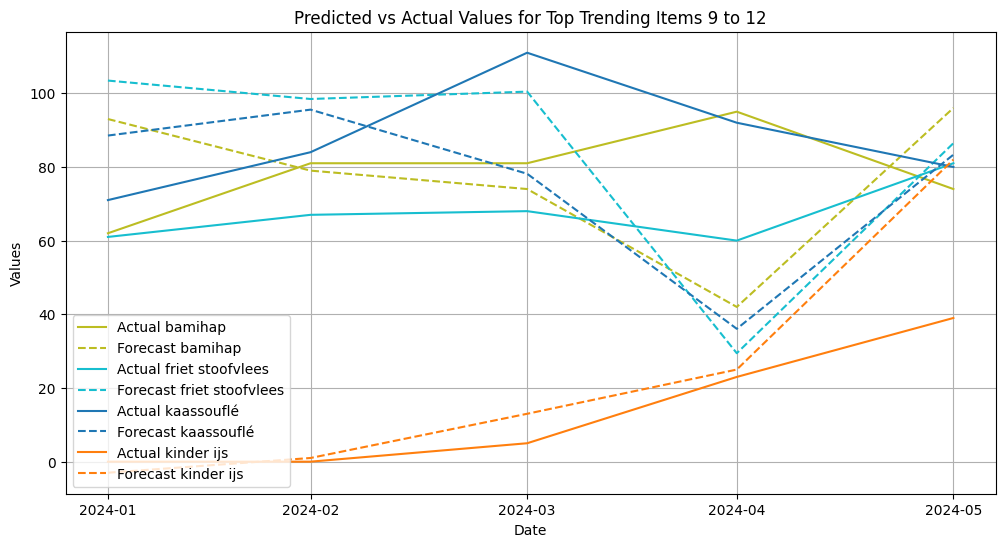

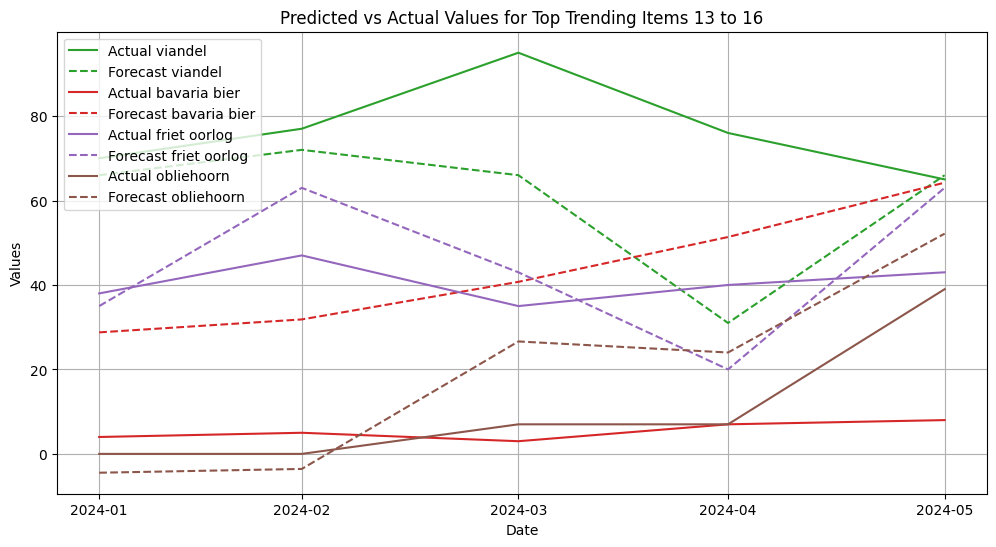

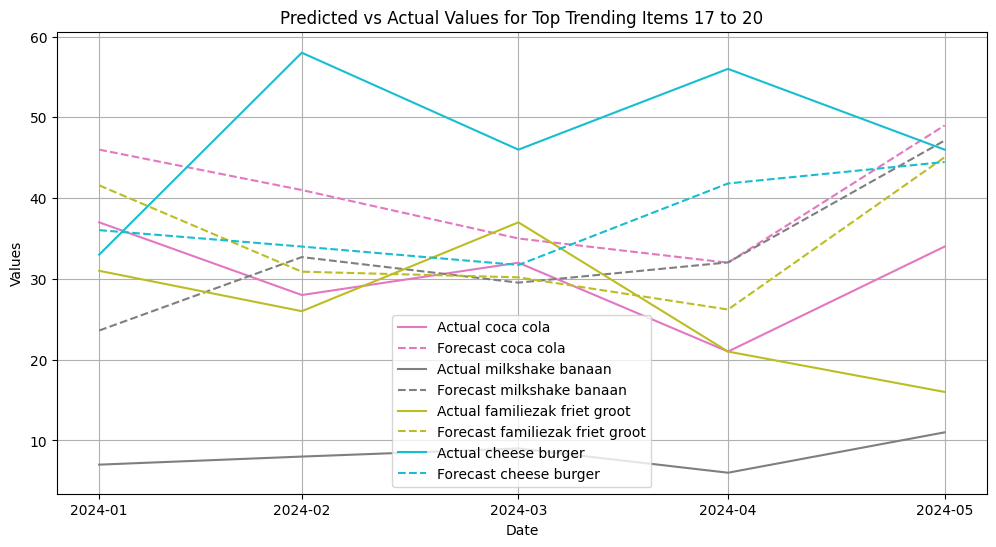

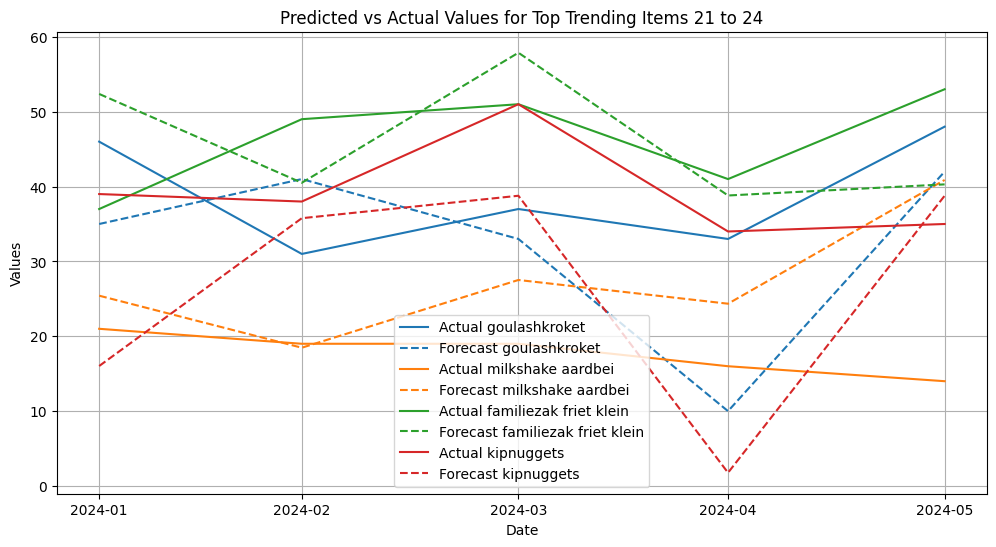

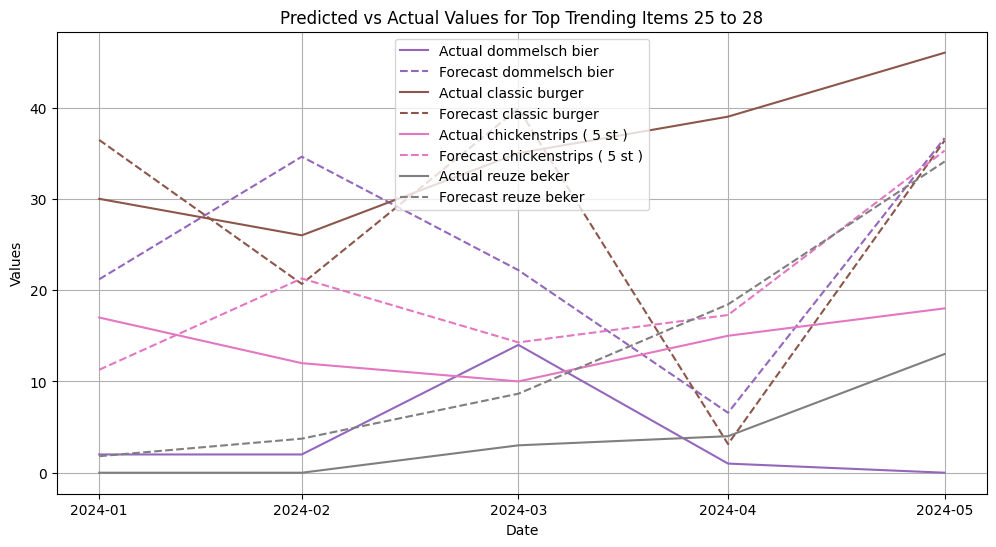

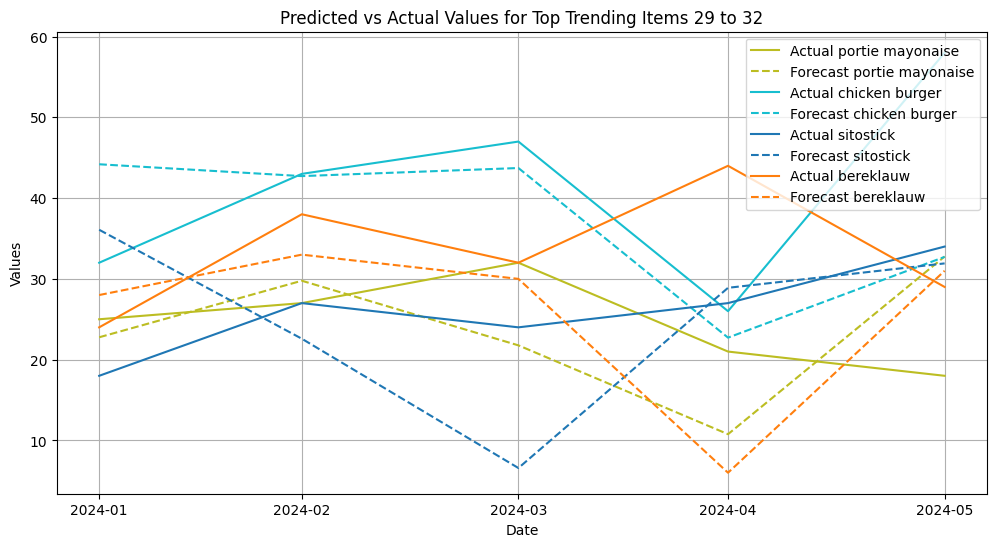

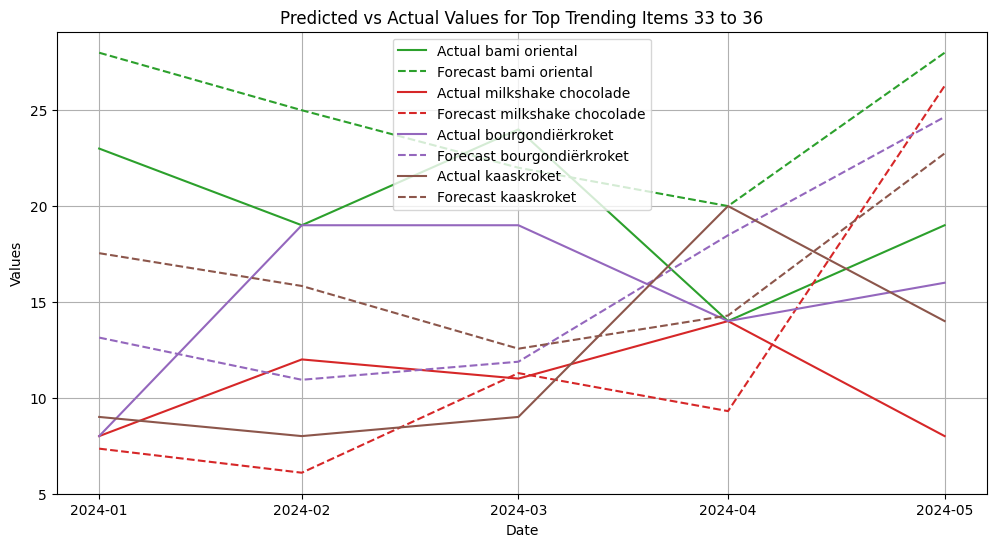

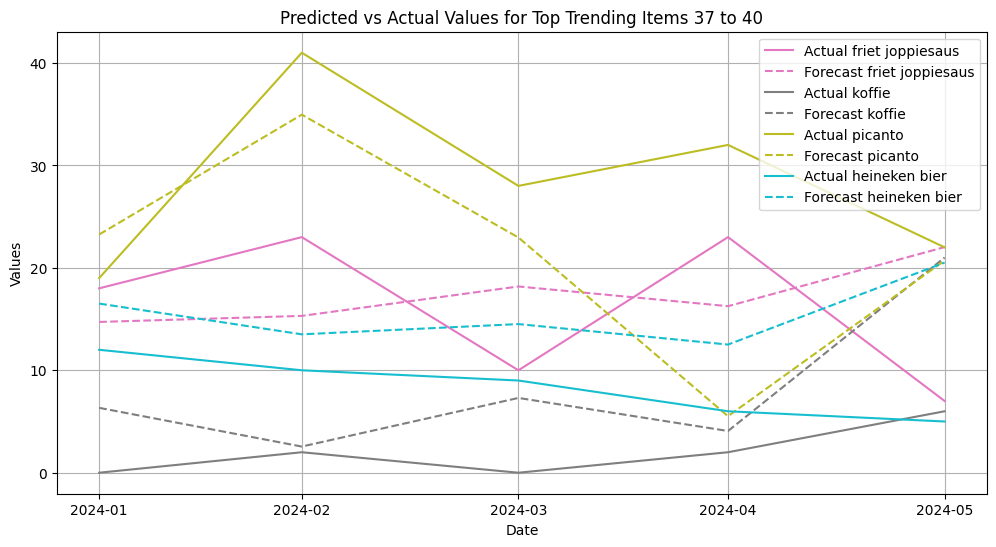

In [50]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import itertools

top_n = 40
batch_size = 4

# Adjust the indexes of the actual df to the forecast df
actual_df.index = forecast_df.index

# Define a color cycle
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

for i in range(0, top_n, batch_size):
    batch_items = trending_items.index[i:i+batch_size]
    plt.figure(figsize=(12, 6))
    for item in batch_items:
        color = next(colors)
        plt.plot(actual_df.index, actual_df[item], label=f'Actual {item}', color=color)
        plt.plot(forecast_df.index, forecast_df[item], linestyle='--', label=f'Forecast {item}', color=color)

    # Set the major formatter to display months only
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=-1))

    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Actual Values for Top Trending Items {i+1} to {i+batch_size}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
last_month_forecast.sort_values(ascending=False).head(40)

frikandel                 250.660801
friet                     197.129502
kroket                    131.621170
friet satésaus            122.408316
frikandel speciaal        118.000000
friet mayonaise           113.000000
friet speciaal            107.000000
mexicano                  102.208181
bamihap                    96.000000
friet stoofvlees           86.440087
kaassouflé                 83.323784
kinder ijs                 82.000000
viandel                    66.000000
bavaria bier               64.227034
friet oorlog               63.000000
obliehoorn                 52.154014
coca cola                  49.000000
milkshake banaan           47.127976
familiezak friet groot     45.053385
cheese burger              44.468800
goulashkroket              42.000000
milkshake aardbei          40.884439
familiezak friet klein     40.291687
kipnuggets                 38.773487
dommelsch bier             36.651469
classic burger             36.387954
chickenstrips ( 5 st )     35.275483
r

In [43]:
rmse_series = pd.Series(rmse_scores)
print("Items with Lowest MSE (Most Accurate Predictions):")
print(rmse_series.sort_values().head(20))

Items with Lowest MSE (Most Accurate Predictions):
sundae chocolade                  1.116652e-15
sundae aardbeien                  6.340344e-14
jochempie                         2.514945e-11
zubr                              1.274057e-03
kwekkeboom kroket                 1.419005e-01
fuze tea ( green tea )            4.112416e-01
bitterlemon                       4.138539e-01
vietnamese loempia                4.606711e-01
menu varkenshaas                  6.569704e-01
menu chicken burger               7.195188e-01
radler                            7.208138e-01
ronde wafel                       8.002709e-01
menu easy egg burger              8.290793e-01
menu cheese burger                8.398472e-01
portie tomotto saus               9.671400e-01
visstick                          9.774930e-01
sorbet kersen                     1.000000e+00
chickenwings ( 10 st )            1.046621e+00
bucket chickenstrips ( 13 st )    1.055379e+00
fernandes groen                   1.067446e+00
dtype: fl

In [44]:
print("Items with Highest MSE (Lowest Accurate Predictions):")
print(rmse_series.sort_values(ascending=False).head(20))

Items with Highest MSE (Lowest Accurate Predictions):
frikandel speciaal    121.211386
friet                  70.402477
friet speciaal         60.909769
kroket                 54.039806
bavaria bier           39.717406
friet satésaus         38.148308
frikandel              37.920049
friet mayonaise        32.205590
sundae                 31.016285
friet stoofvlees       31.001619
kaassouflé             30.527266
bamihap                29.349617
kipkorn                27.855617
milkshake banaan       25.654504
mexicano               25.414003
viandel                24.116384
dommelsch bier         23.970802
kinder ijs             19.631607
kipnuggets             18.627576
spa blauw              17.667565
dtype: float64


# Conclusion

In this notebook I have analyzed the dataset of the POS system Sitedish and applied Long Short-Term Memory (LSTM) and Seasonal Auto-Regressive Integrated Moving Average (SARIMA) to predict the optimal timing for selling certain food items within periods such as a week or month.

Firstly, I have cleaned the dataset by removing unmeaningful food items, cleaning food items with extra annotations or capitalizations, and removing food items with less than 30 orders. I have visualized the data by plotting the amount of orders and revenue per day. The revenue per day plot contained two significant outliers which were removed from the dataset. The data cleaning resulted in 165 different food items in the dataset.

Secondly, I have preprocessed the data for the LSTM model by creating a pivot table, normalizing the data, and creating sequences of 30-days for the model. The LSTM model has been trained with different network configurations and has been able to predict trending food items. The model's evaluation is the mean squared error (MSE), therefore it is possible to easily test out different network configurations. I have plotted out the top 40 trending food items. This resulted in the following values: 0.007 on the training set, 0.018 on the test set and 0.013 on the validation set.

Thirdly, I applied SARIMA for predicting trending food items. SARIMA requires training on each food item individually whereas LSTM can input multiple food items. This is due to SARIMA's design of statistically handling single time series data. The SARIMA model has been trained on the monthly data and has been able to predict the trending food items as well. The model's evaluation is the mean squared error (RMSE) because RMSE impact of large errors is more significant than smaller errors. SARIMA results in an output that takes longer to analyse since each food item contains a SARIMA model with different parameters.

The surprising part is that items with a high monthly order amount have a higher RMSE score, which is counterintuitive. This could be due to that the model having difficulties predict the high variance in the data. On the other hand, items that are predicted with the lowest RMSE are the items with an exceptionally monthly order amount. I think this is due to model predicting a low order amount for these items, which relatively is easier to predict accurately. 
Additionally, there are 34 rows of monthly data in total, and the model has been trained on 29 months of data and tested on 5 months of data. The model predicts most of the amount of orders in the range, however I notice a lower prediction on the 4th month April in 2024. When looking back at the previous revenue plot, I see that this is caused by a holiday period during April 2023, which makes this month an outlier in the dataset. Additionally, with more data, both models could potentially predict the number of orders more accurately, thereby identifying trending food items more precisely.

I conclude that LSTM works better for predicting trending food items since it can handle multiple food items and predict the amount of orders more accurately.